In [1]:
import nltk
import pandas as pd
# import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

#from google.colab import files
#import io

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from nltk.util import ngrams

#import gensim
#from gensim.models import Phrases
#from gensim.corpora import Dictionary

import warnings

warnings.filterwarnings("ignore")

seed = 42
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gereo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gereo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gereo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gereo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gereo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
stop_words = stopwords.words('english')

stop_words.extend([
    "process", "improve", "improvement", "data"
])

stop_words.extend([
    "generative", "neural", "network", "gnn", "model"
])

stop_words.extend([
    "this", "paper", "study", "artifact", "method"
])

lemma = WordNetLemmatizer()
stop_words_lem = [lemma.lemmatize(s) for s in stop_words]
stop_words.extend(stop_words_lem)

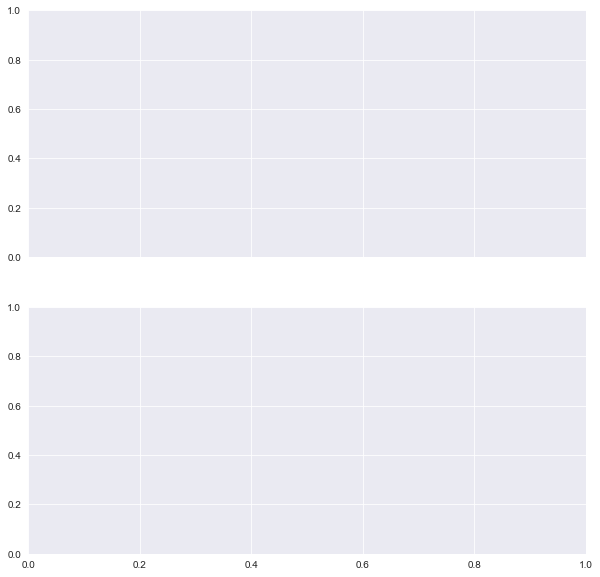

In [3]:
from nltk.corpus import wordnet


## Lemmatizer with POS tag
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, articles):
        return [self.wnl.lemmatize(t, get_wordnet_pos(t)) for t in word_tokenize(articles) if t not in stop_words]


def clean_text(data, column):
    data[column] = data[column].str.replace('\d+', '').str.lower()  # for digits
    data[column] = data[column].str.replace(r'(\b\w{1,2}\b)', '').str.lower()  # for words
    data[column] = data[column].str.replace('[^\w\s]', '').str.lower()  # for punctuation


def add_column(data, keywords):
    for kw in keywords:
        data[kw] = data["txt"].str.contains(kw, regex=False)


def plt_dist_total(keywords, title, topics, df):
    add_column(df, keywords)
    k_sum = {}
    r = np.arange(len(keywords))
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    for t in topics:
        k_sum[t] = {}
        for i, k in enumerate(keywords):
            k_sum[t][k] = int((df.loc[(df[t] == True)][k].sum()))
        v1 = ax.bar(x=r, height=k_sum[t].values(), width=0.2)
        r = r + 0.2
    ax.set_xticks([s + 0.3 for s in range(len(v1))])
    ax.set_xticklabels(keywords, rotation=70, fontsize=16)
    ax.legend(topics, fontsize=16)
    ax.set_ylabel('No of papers per topic', fontsize=16)
    ax.set_title(title, fontsize=18)
    #plt.style.use('default')


def plt_dist_perc(keywords, title, topics, df):
    add_column(df, keywords)
    k_sum = {}
    r = np.arange(len(keywords))
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    for t in topics:
        k_sum[t] = {}
        for i, k in enumerate(keywords):
            k_sum[t][k] = int((df.loc[(df[t] == True)][k].sum() / len(df.loc[(df[t] == True)])) * 100)
        v1 = ax.bar(x=r, height=k_sum[t].values(), width=0.2)
        r = r + 0.2
    ax.set_xticks([s + 0.3 for s in range(len(v1))])
    ax.set_xticklabels(keywords, rotation=70, fontsize=16)
    ax.legend(topics, fontsize=16)
    ax.set_ylabel('% of papers per topic', fontsize=16)
    ax.set_title(title, fontsize=18)
    #plt.style.use('default')


def plt_corr(data, keywords):
    corr = data[keywords].corr()
    ax = sns.heatmap(
        corr,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )


def heatmap(title, x, y, size):
    fig, ax = plt.subplots()

    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]: p[0] for p in enumerate(x_labels)}
    y_to_num = {p[1]: p[0] for p in enumerate(y_labels)}

    size_scale = 600
    ax.scatter(
        x=x.map(x_to_num),  # Use mapping for x
        y=y.map(y_to_num),  # Use mapping for y
        s=size * size_scale,  # Vector of square sizes, proportional to size parameter
        c=size * size_scale,
        cmap="RdBu",
        marker='s'  # Use square as scatterplot marker
    )

    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.title(title)
    #plt.colorbar(ax.imshow(np.arange(0,1,0.01).reshape((10, 10)), cmap="RdBu"))

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])


def plot_scatter(cat1, cat2, df, topics):
    for t in topics:
        c_old = df[df[t] == 1][cat1 + cat2].corr()
        c = c_old[cat2][0:len(cat1)]
        #print(c)
        c = pd.melt(c.reset_index(), id_vars='index')  # Unpivot the dataframe, so we can get pair of arrays for x and y
        c.columns = ['x', 'y', 'value']
        title = str(t)
        heatmap(title,
                x=c['x'],
                y=c['y'],
                size=c['value'].abs()
                )


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)


def sum_plot(data, outlet, column, top):
    sums = data[data[outlet] == True].groupby(column).agg({top: "sum"})
    sums = sums.replace(0, np.nan)
    return sums




# Business Process Redesign

In [4]:
df_bpr = pd.read_csv("bpr-lit.csv", sep=";").drop_duplicates(subset=["Article Title"])
print("The dataset contains %i papers.\n" % len(df_bpr))

print("No. of papers without abstract: " + str(df_bpr["Abstract"].isna().sum()))
print("No. of papers without tags: " + str(df_bpr[
                                               "Author Keywords"].isna().sum()))  # TODO: Not sure if there is an equivalent to tags in Google Scholar search?

The dataset contains 208 papers.

No. of papers without abstract: 14
No. of papers without tags: 57


In [5]:
#remove special characters in titles + abstracts
i = ["Abstract", "Article Title"]
for i in i:
    clean_text(df_bpr, i)

#subset dataset to only include english publications
languages = ["English", "eng"]
df_bpr_en = df_bpr.loc[df_bpr['Language'].isin(languages)]

#create new column with all textual data
df_bpr_en["txt"] = df_bpr_en["Article Title"] + df_bpr_en["Abstract"].fillna("") + df_bpr_en["Author Keywords"].fillna(
    "")

#create df with abstracts
df_bpr_en_abstracts = df_bpr_en["Abstract"]

# #add analysis keywords
# # TODO: These all need to redefined
# keywords = ["review", "state of the art", "stateoftheart", "patient journey", "clinical pathway", "care map", "patient flow", "patientflow"]
# topics = ["patient journey", "clinical pathway", "patient flow", "care map"]
# diseases = ["hip replacement", "knee replacement", "arthroplasty", "cancer", "cardiovascular", "stroke", "heart", "myocardial", "coronary", "kidney", "pulmonary","pneumonia", "asthma", "diabetes", "arthritis"]
# study_types = [ "systematic review", "qualitative", "quantitative", "interview", "focus group",  "simulation", "markov", "stochastic", "queuing", "mining", "machine learning", "predictive", "forecast", "prescriptive", "optimization", "mapping", "modeling", "process mining", "workflow"]
# encounter = ["inpatient","ambulatory", "outpatient", "acute", "chronic", "elective", "observation", "preadmission", "virtual"]
# patient_cat = ["emergency care", "urgent care", "stabilization", "prehospital", "critical care", "trauma", "chronic care"]
# goals = ["waiting", "throughput", "crowding", "noshow", "reimbursement", "readmission", "quality", "experience", "patient experience", "utilization", "staffing", "satisfaction", "drg", "revenue", "cost"]
# dept = ["anesthetics", "cardiology", "gastroenterology", "general surgery", "gynecology", "hematology", "neonatal", "neurology", "ophtalmology", "orthopedics", "oncology", "physiotherapy", "radiology", "renal unit", "urology"]
# area = ["operating room", "emergency department", "icu", "intensive care unit"]
# cats = [keywords, topics, diseases, study_types, encounter, patient_cat, goals, dept]
#
# for c in cats:
#     add_column(df_bpr_en, c)
#
# df_bpr_en["sota"] = (df_bpr_en["state of the art"] | df_bpr_en["stateoftheart"])
# df_bpr_en["patient flow"] = (df_bpr_en["patient flow"] | df_bpr_en["patientflow"])
# del df_bpr_en["state of the art"]
# del df_bpr_en["stateoftheart"]
# del df_bpr_en["patientflow"]
#
# df_bpr_en.head()

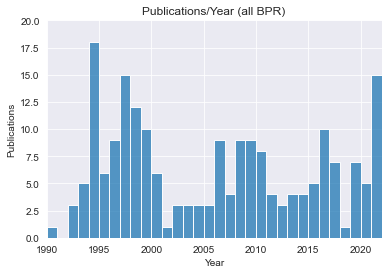

19


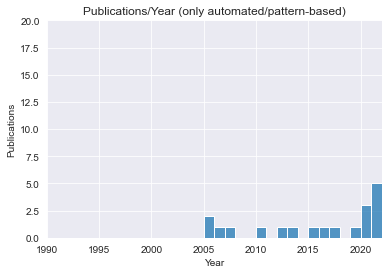

In [6]:
# print(df_bpr_en["Publication Year"])

sns.histplot(df_bpr_en["Publication Year"], binwidth=1)
plt.ylim(0, 20)
plt.xlim(1990, 2022)
plt.ylabel("Publications")
plt.xlabel("Year")
plt.title("Publications/Year (all BPR)")
plt.show()

df_abpr = df_bpr_en.loc[
    df_bpr_en['txt'].str.contains("automated", regex=False, case=False)
    + df_bpr_en['txt'].str.contains("pattern", regex=False, case=False)
    + df_bpr_en['txt'].str.contains("heuristics", regex=False, case=False)
    ]
print(len(df_abpr))

sns.histplot(df_abpr["Publication Year"], binwidth=1)
plt.ylim(0, 20)
plt.xlim(1990, 2022)
plt.ylabel("Publications")
plt.xlabel("Year")
plt.title("Publications/Year (only automated/pattern-based)")
plt.show()

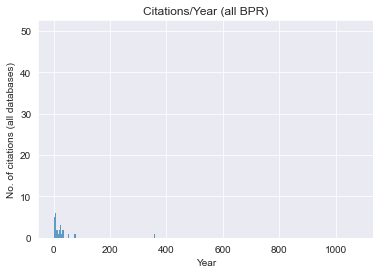

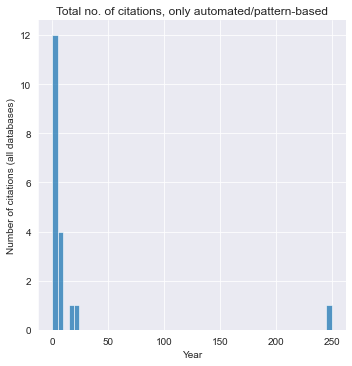

In [7]:
# plt.hist(df_bpr_en["Times Cited, All Databases"])
sns.histplot(df_bpr_en["Times Cited, All Databases"], binwidth=1)
plt.ylabel("No. of citations (all databases)")
plt.xlabel("Year")
plt.title("Citations/Year (all BPR)")
plt.show()

df_abpr = df_bpr_en.loc[
    df_bpr_en['txt'].str.contains("automated", regex=False, case=False)
    + df_bpr_en['txt'].str.contains("pattern", regex=False, case=False)
    + df_bpr_en['txt'].str.contains("heuristics", regex=False, case=False)
    ]

sns.displot(df_abpr["Times Cited, All Databases"])
plt.ylabel("Number of citations (all databases)")
plt.xlabel("Year")
plt.title("Total no. of citations, only automated/pattern-based")
plt.show()

Publication Year
1990    1079
1992      86
1993      92
1994     302
1995      66
1996     289
1997     553
1998     561
1999     717
2000      98
2001       0
2002     112
2003     102
2004      11
2005     334
2006      96
2007       9
2008      75
2009     161
2010      32
2011       5
2012      20
2013      15
2014       9
2015      52
2016     156
2017      73
2018       2
2019      84
2020      24
2021       8
2022       3
Name: Times Cited, All Databases, dtype: int64


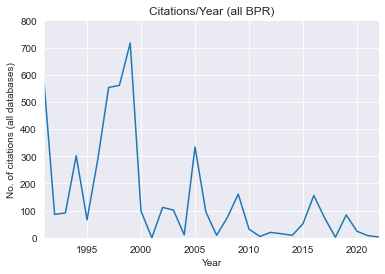

   Publication Type                                            Authors  \
0                 J  Fehrer, T; Fischer, DA; Leemans, SJJ; Roglinge...   
1                 C  Milani, F; Garcia-Banuelos, L; Reijers, HA; St...   
11                C                Mustansir, A; Shahzad, K; Malik, MK   
14                J                           Reijiers, HA; Mansar, SL   
15                J                Mustansir, A; Shahzad, K; Malik, MK   

                                    Author Full Names  \
0   Fehrer, Tobias; Fischer, Dominik A.; Leemans, ...   
1   Milani, Frederik; Garcia-Banuelos, Luciano; Re...   
11  Mustansir, Amina; Shahzad, Khurram; Malik, Muh...   
14                           Reijiers, HA; Mansar, SL   
15  Mustansir, Amina; Shahzad, Khurram; Malik, Muh...   

                                        Article Title  \
0        assisted approach  business process redesign   
1   business process redesign heuristics for block...   
11  autoeprs extracting business process 

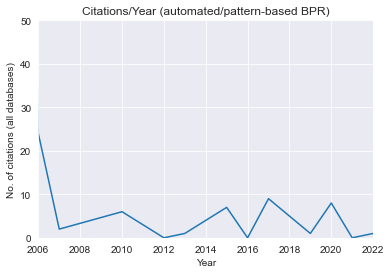

In [8]:
citations_all = df_bpr_en["Times Cited, All Databases"].groupby(df_bpr_en["Publication Year"]).sum()
print(citations_all)
citations_all.plot()
plt.xlim(1991, 2022)
plt.ylim(0,800)
plt.ylabel("No. of citations (all databases)")
plt.xlabel("Year")
plt.title("Citations/Year (all BPR)")
plt.show()

df_abpr = df_bpr_en.loc[
    df_bpr_en['txt'].str.contains("automated", regex=False, case=False)
    + df_bpr_en['txt'].str.contains("pattern", regex=False, case=False)
    + df_bpr_en['txt'].str.contains("heuristics", regex=False, case=False)
    ]

print(df_abpr.head())

citations_abpr = df_abpr["Times Cited, All Databases"].groupby(df_bpr_en["Publication Year"]).sum()
citations_abpr.plot()
plt.xlim(2006, 2022)
plt.ylim(0,50)
plt.ylabel("No. of citations (all databases)")
plt.xlabel("Year")
plt.title("Citations/Year (automated/pattern-based BPR)")
plt.show()

In [9]:
# Papers that mention KPIs
words = ["key performance indicator", "kpi"]
print("Papers that mention KPIs: " + str(
    len(df_bpr_en[df_bpr_en["txt"].str.contains('|'.join(words), case=False)]["txt"])))

words = ["pattern"]
print("Papers that mention patterns: " + str(
    len(df_bpr_en[df_bpr_en["txt"].str.contains('|'.join(words), case=False)]["txt"])))

Papers that mention KPIs: 3
Papers that mention patterns: 9


In [10]:
words = ["pattern"]
print("Papers that mention patterns: " + str(
    len(df_abpr[df_bpr_en["txt"].str.contains('|'.join(words), case=False)]["txt"])))
print("Total no. of papers in APBR corpus: " + str(len(df_abpr["txt"])))

Papers that mention patterns: 9
Total no. of papers in APBR corpus: 19


In [11]:
print("BPR:")
words = [""]
print("Total papers: " + str(
    len(df_bpr_en[df_bpr_en["txt"].str.contains('|'.join(words), case=False)]["txt"])))

words = ["case study"]
print("Papers that mention case study: " + str(
    len(df_bpr_en[df_bpr_en["txt"].str.contains('|'.join(words), case=False)]["txt"])))

words = ["review"]
print("Papers that mention review: " + str(
    len(df_bpr_en[df_bpr_en["txt"].str.contains('|'.join(words), case=False)]["txt"])))

words = ["invention"]
print("Papers that mention invention: " + str(
    len(df_bpr_en[df_bpr_en["txt"].str.contains('|'.join(words), case=False)]["txt"])))

print("ABPR:")
words = [""]
print("Total papers: " + str(
    len(df_abpr[df_abpr["txt"].str.contains('|'.join(words), case=False)]["txt"])))

words = ["case study"]
print("Papers that mention case study: " + str(
    len(df_abpr[df_abpr["txt"].str.contains('|'.join(words), case=False)]["txt"])))

words = ["review"]
print("Papers that mention review: " + str(
    len(df_abpr[df_abpr["txt"].str.contains('|'.join(words), case=False)]["txt"])))

words = ["invention"]
print("Papers that mention invention: " + str(
    len(df_abpr[df_abpr["txt"].str.contains('|'.join(words), case=False)]["txt"])))


BPR:
Total papers: 202
Papers that mention case study: 46
Papers that mention review: 16
Papers that mention invention: 0
ABPR:
Total papers: 19
Papers that mention case study: 5
Papers that mention review: 2
Papers that mention invention: 0


In [12]:
print("BPR:")
words = ["concept drift"]
print("Total papers: " + str(
    len(df_bpr_en[df_bpr_en["txt"].str.contains('|'.join(words), case=False)]["txt"])))

print("ABPR:")
words = ["concept drift"]
print("Total papers: " + str(
    len(df_abpr[df_abpr["txt"].str.contains('|'.join(words), case=False)]["txt"])))


BPR:
Total papers: 0
ABPR:
Total papers: 0


In [13]:
# Get number of unique authors:
# num_unique_authors = df_bpr_en["Authors"].nunique()

df_bpr_en["Authors List"] = df_bpr_en["Authors"].str.split(";")
df_exploded = df_bpr_en.explode("Authors List")
df_exploded.drop_duplicates(inplace=True)
num_unique_authors = df_exploded["Authors List"].count()
print("BPR: " + str(num_unique_authors))

df_abpr["Authors List"] = df_abpr["Authors"].str.split(";")
df_exploded = df_abpr.explode("Authors List")
df_exploded.drop_duplicates(inplace=True)
num_unique_authors = df_exploded["Authors List"].count()
print("ABPR: " + str(num_unique_authors))

BPR: 519
ABPR: 54


In [14]:
# Get most cited publications
sorted = df_bpr_en.sort_values(by="Times Cited, All Databases", ascending=False)
print(sorted.head())

    Publication Type                                            Authors  \
60                 J                           DAVENPORT, TH; SHORT, JE   
163                J                  Kettinger, WJ; Teng, JTC; Guha, S   
166                J                                     Gunasekaran, A   
75                 J  Malone, TW; Crowston, K; Lee, J; Pentland, B; ...   
12                 J                Broadbent, M; Weill, P; St Clair, D   

                                     Author Full Names  \
60                            DAVENPORT, TH; SHORT, JE   
163                  Kettinger, WJ; Teng, JTC; Guha, S   
166                                     Gunasekaran, A   
75   Malone, TW; Crowston, K; Lee, J; Pentland, B; ...   
12                 Broadbent, M; Weill, P; St Clair, D   

                                         Article Title  \
60   the new industrialengineering  information tec...   
163  business process change  study  methodologies ...   
166  agile manufacturing e

In [15]:
# TODO: not sure if this is useful for anything
# replace True/False with 0/1 for sum calculations
# df_bpr_en.replace(False, 0, inplace=True)
# df_bpr_en.replace(True, 1, inplace=True)

# Generative Graph Neural Networks

In [16]:
df_ggnn = pd.read_csv("ggnn-lit.csv", sep=";").drop_duplicates(subset=["Article Title"])
print("The dataset contains %i papers.\n" % len(df_ggnn))

print("No. of papers without abstract: " + str(df_ggnn["Abstract"].isna().sum()))
print("No. of papers without tags: " + str(df_ggnn[
                                               "Author Keywords"].isna().sum()))

The dataset contains 149 papers.

No. of papers without abstract: 0
No. of papers without tags: 35


In [17]:
#remove special characters in titles + abstracts
i = ["Abstract", "Article Title"]
for i in i:
    clean_text(df_bpr, i)

#subset dataset to only include english publications
languages = ["English", "eng"]
df_ggnn_en = df_ggnn.loc[df_ggnn['Language'].isin(languages)]

#create new column with all textual data
df_ggnn_en["txt"] = df_ggnn_en["Article Title"] + df_ggnn_en["Abstract"].fillna("") + df_ggnn_en[
    "Author Keywords"].fillna("")

#create df with abstracts
df_ggnn_en_abstract = df_ggnn_en["Abstract"]

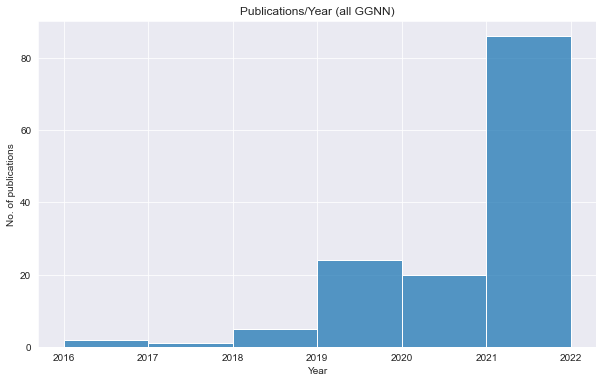

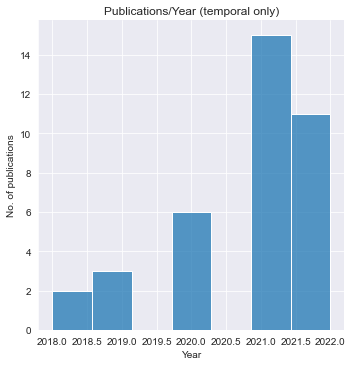

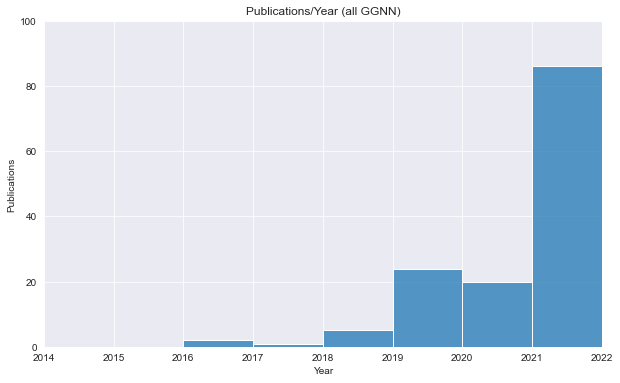

In [18]:
plt.figure(figsize=[10, 6])

sns.histplot(df_ggnn_en["Publication Year"], binwidth=1)
plt.ylabel("No. of publications")
plt.xlabel("Year")
plt.title("Publications/Year (all GGNN)")
plt.show()

df_temporal = df_ggnn_en.loc[
    df_ggnn_en['txt'].str.contains("Temporal", regex=False, case=False)
    + df_ggnn_en['txt'].str.contains("Time", regex=False, case=False)
    ]

sns.displot(df_temporal["Publication Year"])
plt.ylabel("No. of publications")
plt.xlabel("Year")
plt.title("Publications/Year (temporal only)")
plt.show()


plt.figure(figsize=[10, 6])
sns.histplot(df_ggnn_en["Publication Year"], binwidth=1)
plt.ylim(0, 100)
plt.xlim(2014, 2022)
plt.ylabel("Publications")
plt.xlabel("Year")
plt.title("Publications/Year (all GGNN)")
plt.show()

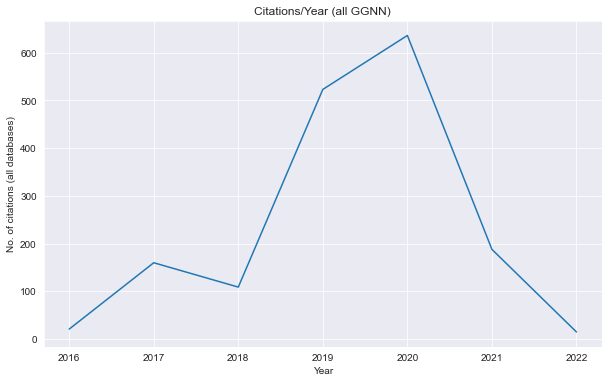

Publication Year
2016.0     21
2017.0    160
2018.0    109
2019.0    523
2020.0    636
2021.0    188
2022.0     15
Name: Times Cited, All Databases, dtype: int64


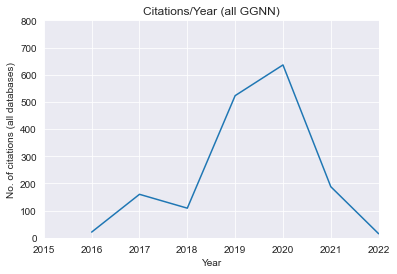

In [19]:
plt.figure(figsize=[10, 6])

citations_all = df_ggnn_en["Times Cited, All Databases"].groupby(df_ggnn_en["Publication Year"]).sum()
citations_all.plot()
plt.ylabel("No. of citations (all databases)")
plt.xlabel("Year")
# plt.xlim(1990, 2023)
plt.title("Citations/Year (all GGNN)")
plt.show()




citations_all = df_ggnn_en["Times Cited, All Databases"].groupby(df_ggnn_en["Publication Year"]).sum()
print(citations_all)
citations_all.plot()
plt.xlim(2015, 2022)
plt.ylim(0,800)
plt.ylabel("No. of citations (all databases)")
plt.xlabel("Year")
plt.title("Citations/Year (all GGNN)")
plt.show()

In [20]:
words = ["recurrent", "autoregressive"]
print(str(len(df_ggnn_en[df_ggnn_en["txt"].str.contains('|'.join(words), case=False)]["txt"])) + " papers mention recurrent:")

words = ["single-shot", "single", "shot"]
print(str(len(df_ggnn_en[df_ggnn_en["txt"].str.contains('|'.join(words), case=False)]["txt"])) + " papers mention single-shot generation:")

words = ["temporal"]
print(str(len(df_ggnn_en[df_ggnn_en["txt"].str.contains('|'.join(words), case=False)]["txt"])) + " papers mention temporal dependencies:")

21 papers mention recurrent:
15 papers mention single-shot generation:
17 papers mention temporal dependencies:


In [21]:
words = ["dynamic graphs", "dynamic graph"]
print(str(len(df_ggnn_en[df_ggnn_en["txt"].str.contains('|'.join(words), case=False)]["txt"])) + " papers mention dynamic graphs:")
print(df_ggnn_en[df_ggnn_en["txt"].str.contains('|'.join(words), case=False)]["Article Title"])

8 papers mention dynamic graphs:
9              Stochastic graph recurrent neural network
16     EvoNet: A Neural Network for Predicting the Ev...
25     DynGraphGAN: Dynamic Graph Embedding via Gener...
32     Coupled Graph ODE for Learning Interacting Sys...
69     Variational Graph Neural Networks for Road Tra...
91     Spatio-Temporal Graph Dual-Attention Network f...
97     Representation Learning for Dynamic Functional...
114    An investigation into the deep learning approa...
Name: Article Title, dtype: object


In [22]:
# Get most cited publications
sorted = df_ggnn_en.sort_values(by="Times Cited, All Databases", ascending=False)
print(sorted.head())

    Publication Type                                            Authors  \
144                J                          van Engelen, JE; Hoos, HH   
142                J     Elton, DC; Boukouvalas, Z; Fuge, MD; Chung, PW   
36                 J  Li, J; Xu, K; Chaudhuri, S; Yumer, E; Zhang, H...   
56                 J                                         Jensen, JH   
93                 J  Gao, L; Yang, J; Wu, T; Yuan, YJ; Fu, HB; Lai,...   

    Book Editors Book Group Authors  \
144          NaN                NaN   
142          NaN                NaN   
36           NaN                NaN   
56           NaN                NaN   
93           NaN                NaN   

                                     Author Full Names  \
144            Van Engelen, Jesper E.; Hoos, Holger H.   
142  Elton, Daniel C.; Boukouvalas, Zois; Fuge, Mar...   
36   Li, Jun; Xu, Kai; Chaudhuri, Siddhartha; Yumer...   
56                                      Jensen, Jan H.   
93   Gao, Lin; Yang, Jie